In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from spike_training import *
from rate_training import *

In [3]:
n_par, time_par, train_par, conn_par, run_par = create_default_params()

In [4]:
def gen_rand_stim(n_par, time_par):
    N = n_par['net_size']
    dt = time_par['dt']
    timesteps = int(time_par['total_time']/dt)
    
    stim = np.zeros((N, timesteps))
    for row in range(N):
        rstim = 2 * sp.stats.uniform.rvs(0, 1) - 1 # random stim weight from -1, 1
        stim[row][int(time_par['stim_on']/dt):int(time_par['stim_off']/dt)] = rstim
    return stim

In [5]:
stim = gen_rand_stim(n_par, time_par)

In [6]:
# fout, driving stim set to our data
timesteps = int(time_par['total_time']/time_par['dt'])
N = n_par['net_size']
raw_waveforms = np.transpose(np.load("raw_form.npy"))
fout = raw_waveforms[0][0:timesteps]
inp_w = sp.stats.uniform.rvs(size = N)
fdrive = np.outer(inp_w, fout)

In [7]:
rtrainer = rate_training(n_par, time_par, train_par, conn_par, run_par)

In [8]:
x, Hx = rtrainer.run_rate(stim + fdrive)

Text(0.5, 1.0, 'Sample driven neuronal behavior')

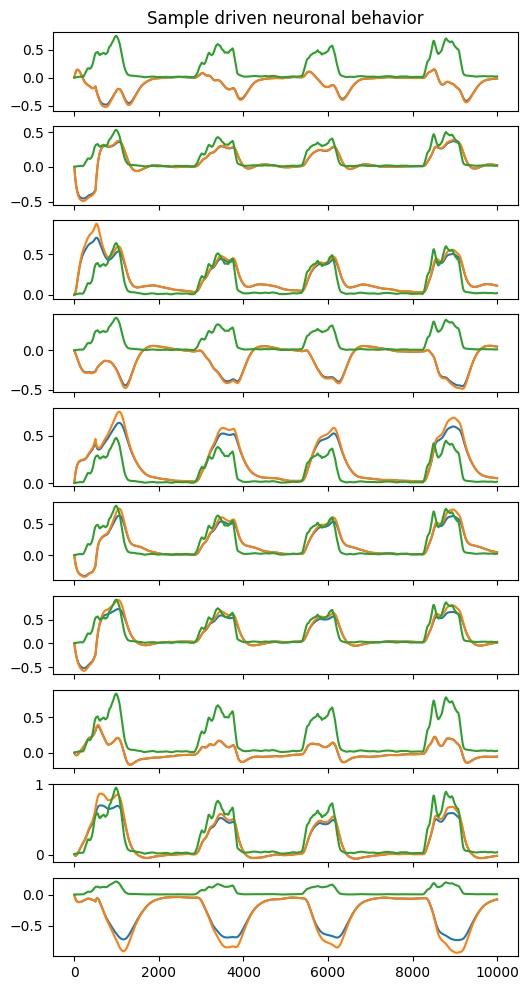

In [9]:
n_plot = 10

fig, axs = plt.subplots(n_plot, 1, figsize = (6, 12), sharex = True)
for i in range(n_plot):
    axs[i].plot(Hx[i])
    axs[i].plot(x[i])
    axs[i].plot(fdrive[i])
    #axs[i].plot(stim[i])

axs[0].set_title("Sample driven neuronal behavior")

In [10]:
# generate auxillary targets
# internal activity plus external activity

aux_targs = Hx + fdrive

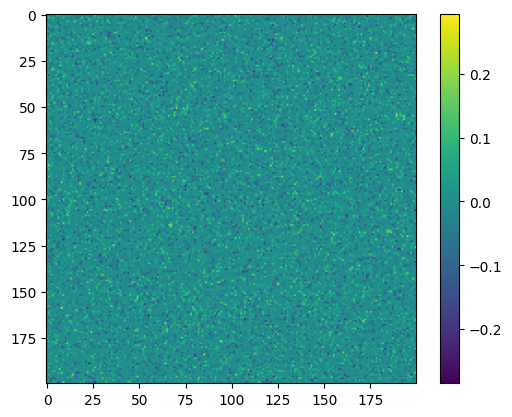

In [11]:
W_driven = rtrainer.W_trained
plt.imshow(W_driven)
plt.colorbar()

In [12]:
task_gen = rate_training(n_par, time_par, train_par, conn_par, run_par)

In [13]:
x_t, Hx_t = task_gen.train_rate(stim, aux_targs)

training trial 0
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200

(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err

(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err

(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err

(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err

(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err

(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err

(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err

(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err

(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err

(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err

(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err

(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err
(200, 200)
(200,) err

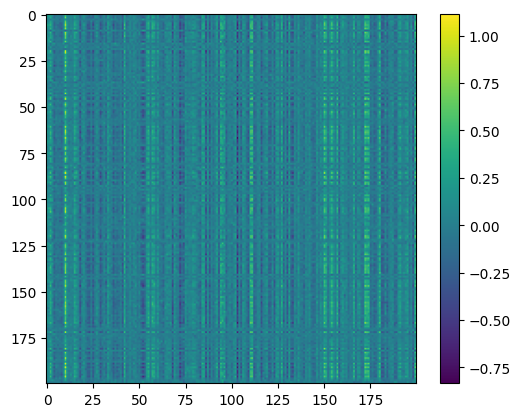

In [14]:
plt.imshow(task_gen.W_trained)
plt.colorbar()

In [15]:
np.shape(Hx_t)

(200, 100000)

Text(0.5, 1.0, 'Sample task network behavior')

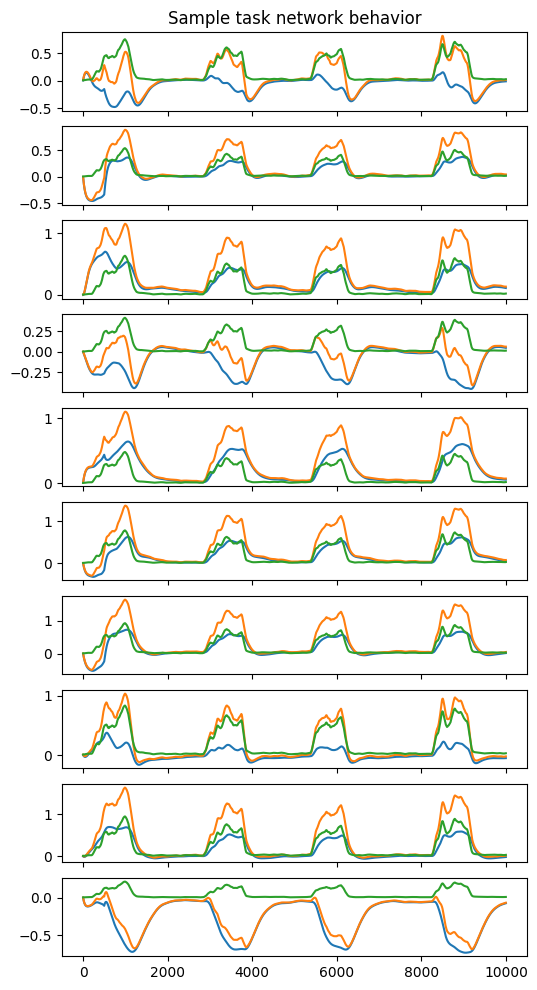

In [16]:
n_plot = 10

fig, axs = plt.subplots(n_plot, 1, figsize = (6, 12), sharex = True)
for i in range(n_plot):
    axs[i].plot(Hx[i])
    axs[i].plot(aux_targs[i])
    axs[i].plot(fdrive[i])

axs[0].set_title("Sample task network behavior")